# Bayesian Optimization for Rosenbrock Function

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.optimize import rosen

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from bayesian_optimization import BayesianOptimizer

### Target function

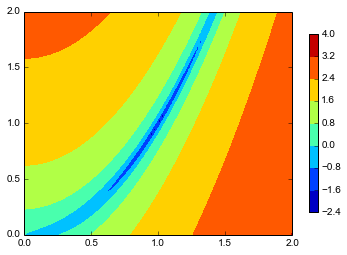

In [5]:
# Plot true function
xi = np.linspace(0, 2, 100)
yi = np.linspace(0, 2, 100)
Xi, Yi = np.meshgrid(xi, yi)

Zi = np.array([np.log10(rosen([xi_, yi_])) for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
CS = plt.contourf(Xi, Yi, Zi)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

### Gaussian Process

In [6]:
x = np.random.uniform(0, 2, size=(2, 100))
y = rosen(x)

Learned kernel: 100**2 * RBF(l=[0.232, 0.851])


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


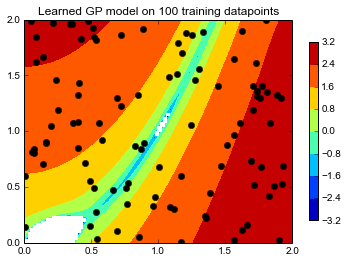

In [7]:
kernel = C(100.0, (1.0, 10000.0)) \
    * RBF(l=(1.0, 1.0), l_bounds=[(0.1, 100), (0.1, 100)])

gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(x.T, y)
print "Learned kernel: %s" % gp.kernel_

Zi = np.array([np.log10(gp.predict([xi_, yi_])) for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
CS = plt.contourf(Xi, Yi, Zi)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# Plot samples
plt.plot(x[0], x[1], 'ko')

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title("Learned GP model on %s training datapoints" % x.shape[1])

### Bayesian Optimization

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:279: RuntimeWarning: invalid value encountered in sqrt
  return y_mean, np.sqrt(y_var)
/home/afabisch/Projekte/bayesian_optimization/bayesian_optimization/bayesian_optimization.py:179: RuntimeWarning: invalid value encountered in greater_equal
  if not np.all(np.logical_and(x >= self.boundaries[:, 0],
/home/afabisch/Projekte/bayesian_optimization/bayesian_optimization/bayesian_optimization.py:180: RuntimeWarning: invalid value encountered in less_equal
  x <= self.boundaries[:, 1])):


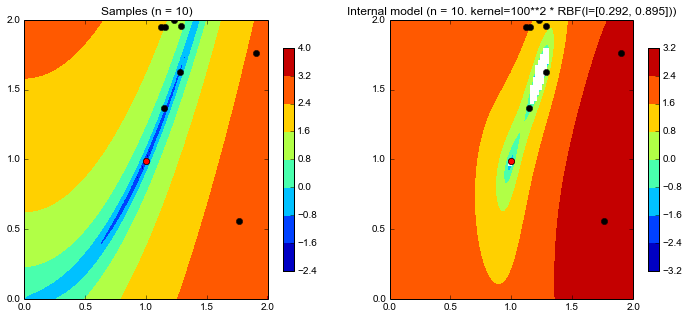

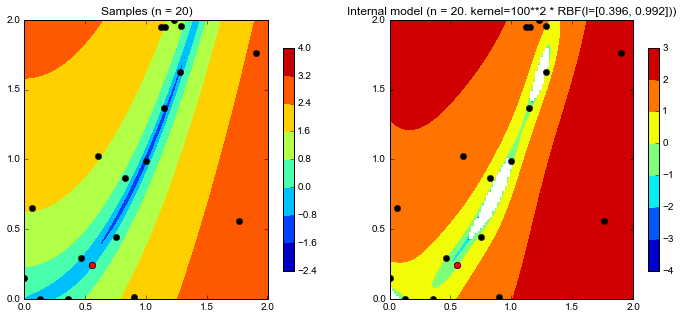

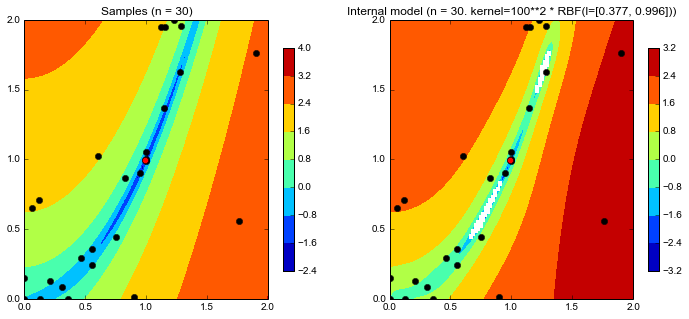

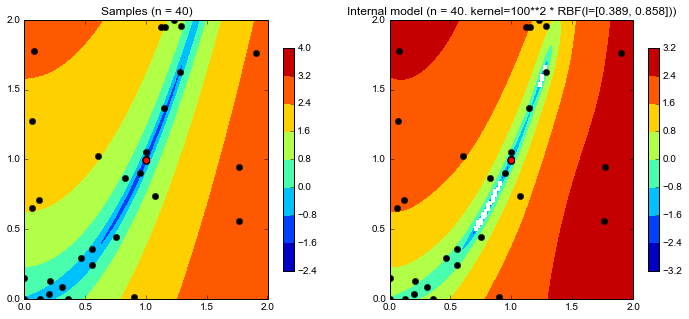

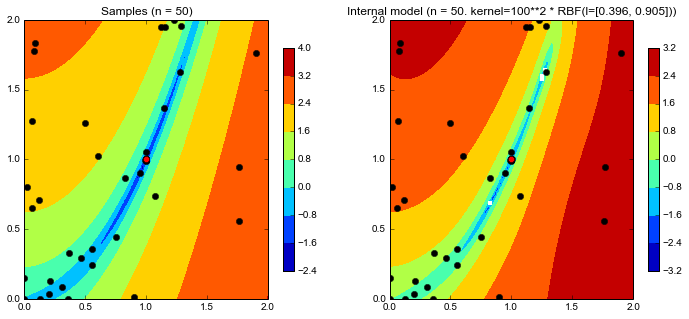

In [8]:
opt = BayesianOptimizer(boundaries=[(0, 2), (0, 2)],
                        acquisition_function="ucb",
                        gp_kwargs=dict(kernel=kernel, 
                                       normalize_y=True, 
                                       sigma_squared_n=1e-3),
                        optimizer="direct+lbfgs",
                        optimizer_kwargs={"maxf": 50},
                        kappa=1.0)
opt.init(2)
x0 = np.array([0.0, 0.0])

scores = []

fig_counter = 0
for step in range(50):
    if (step + 1) % 10 == 0:
        plt.figure(fig_counter, figsize=(12, 5))
        fig_counter += 1

        # Plot true function
        plt.subplot(1, 2, 1)
        xi = np.linspace(0, 2, 100)
        yi = np.linspace(0, 2, 100)
        Xi, Yi = np.meshgrid(xi, yi)

        Zi = np.array([np.log10(rosen([xi_, yi_]))
                       for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
        CS = plt.contourf(Xi, Yi, Zi)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')

        # Plot samples
        thetas = np.array(opt.parameters)
        plt.plot(thetas[:, 0], thetas[:, 1], 'ko')
        plt.plot(thetas[-1:, 0], thetas[-1:, 1], 'ro')

        plt.xlim(0, 2)
        plt.ylim(0, 2)
        plt.title("Samples (n = %s)" % (step + 1))

        # Plot GP model
        plt.subplot(1, 2, 2)
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp.fit(np.vstack(opt.parameters), opt.returns)

        Zi = np.array([np.log10(-gp.predict([xi_, yi_]))
                       for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
        CS = plt.contourf(Xi, Yi, Zi)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')

        # Plot samples
        thetas = np.array(opt.parameters)
        plt.plot(thetas[:, 0], thetas[:, 1], 'ko')
        plt.plot(thetas[-1:, 0], thetas[-1:, 1], 'ro')

        plt.xlim(0, 2)
        plt.ylim(0, 2)
        plt.title("Internal model (n = %s. kernel=%s)" % (step + 1, gp.kernel_))

    opt.get_next_parameters(x0)
    res = -rosen(x0)
    opt.set_evaluation_feedback(res)

    scores.append(res)

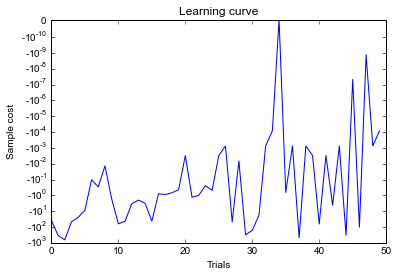

In [9]:
plt.plot(np.array(scores))
plt.yscale("symlog", linthreshy=1e-10)
plt.xlabel("Trials")
plt.ylabel("Sample cost")
plt.title("Learning curve")